<font size=7> Latencies Analysis

In [14]:
import pickle
from human_hip.spike_data import curate_latencies, plot_raster_latency_pairs, plot_vector_layout, plot_latency_dist_hist, plot_latency_angle_hist, \
                                 plot_cross_sttc_pairs, plot_vector_layout2, plot_vector_layout3
from human_hip.animate import animate_latencies


In [15]:
from human_hip.spike_data import curate_latencies, plot_raster_latency_pairs, plot_vector_layout, cross_sttc, plot_pair_analysis, plot_cross_sttc_pairs
import pickle
import matplotlib.pyplot as plt
from ipywidgets import interact_manual
import numpy as np

In [16]:
with open("/workspaces/human_hippocampus/data/ephys/2023-12-03-e-Hc112823_avv9hckcr1/curated_base_acqm.pkl", "rb") as filename:
    sd = pickle.load(filename)

In [17]:
import numpy as np
from human_hip.spike_data import latencies, cross_sttc
from scipy.signal import correlate, correlation_lags
from scipy.ndimage import gaussian_filter
from matplotlib import pyplot as plt

#https://medium.com/@dreamferus/how-to-synchronize-time-series-using-cross-correlation-in-python-4c1fd5668c7a#id_token=eyJhbGciOiJSUzI1NiIsImtpZCI6ImM3ZTExNDEwNTlhMTliMjE4MjA5YmM1YWY3YTgxYTcyMGUzOWI1MDAiLCJ0eXAiOiJKV1QifQ.eyJpc3MiOiJodHRwczovL2FjY291bnRzLmdvb2dsZS5jb20iLCJhenAiOiIyMTYyOTYwMzU4MzQtazFrNnFlMDYwczJ0cDJhMmphbTRsamRjbXMwMHN0dGcuYXBwcy5nb29nbGV1c2VyY29udGVudC5jb20iLCJhdWQiOiIyMTYyOTYwMzU4MzQtazFrNnFlMDYwczJ0cDJhMmphbTRsamRjbXMwMHN0dGcuYXBwcy5nb29nbGV1c2VyY29udGVudC5jb20iLCJzdWIiOiIxMDI5NDUwNDY4Mjk4NDg1MzY1NjYiLCJoZCI6InVjc2MuZWR1IiwiZW1haWwiOiJtZWxsaW90MUB1Y3NjLmVkdSIsImVtYWlsX3ZlcmlmaWVkIjp0cnVlLCJuYmYiOjE2OTM1MTg3MjksIm5hbWUiOiJNYXR0IEVsbGlvdHQiLCJwaWN0dXJlIjoiaHR0cHM6Ly9saDMuZ29vZ2xldXNlcmNvbnRlbnQuY29tL2EvQUFjSFR0ZWRoeVRrWk1hU1hJRTFqa1hhZEVmbmhxc3NwNW1lVFkzUHV0THluMVJ1TXc9czk2LWMiLCJnaXZlbl9uYW1lIjoiTWF0dCIsImZhbWlseV9uYW1lIjoiRWxsaW90dCIsImxvY2FsZSI6ImVuIiwiaWF0IjoxNjkzNTE5MDI5LCJleHAiOjE2OTM1MjI2MjksImp0aSI6Ijc5NGMxOTk1NmI5NDJiNWQzNGIzODc0YTdjYzQ1ZTgyZTlkNjdjZTYifQ.mrDH7b9_D0YfYF3xxqJl-Kh5w_XeWgpyntt19-Bvs4VJJpuJR5DRRJsSGO52guE8jSdYsSDS_ILzPyY_rZAyivCZ4mXJv3CftxbNxgxRD_feS8BNI3YPbTh2Oin7tj32Gzm75Nq4k-UnhQxy9d7qVlw29DA6Wns1yTY0B6cb0pPEuKMWfHmlmCUEtDEDX0dE__pUGkBxWwickpa2n-pW-Z71y-hatFAn80JrOPclPZj1Yts9xeV9uPC7ICWTjSVLZB4Nl8mKy6Rxn6pB_ny01ne06iAoYidx2SwRU3j5BVZF1CK-bhVqQ-qOuzIPj17qvkFE9RJT9Zw842YN9f16MA
def cross_correlation_max_shift(x, y):
    correlations = correlate(x, y, mode="full")
    lags = correlation_lags(x.size, y.size, mode="full")
    return lags[np.argmax(correlations)]

def curate_latencies(sd, cross_sttc_min_cutoff=2, cross_sttc_max_cutoff=15, sttc_cutoff = 0.04, latency_cutoff=1, sigma=15, sttc_delta=20 ):

    # Get all latencies whose STTC is above some minimum STTC cuttoff
    print(sd.N**2 , "Starting Pairs")
    sttc_neo = sd.spike_time_tilings( sttc_delta )    # sttc matrix   
    pairs = []                            # get list (without duplicates) of all pairs above cutoff (excluding diagonal)
    for i in range(sd.N):
        for j in range(i+1,sd.N):
            if sttc_neo[i,j] > sttc_cutoff:
                pairs.append([i,j])
    print( len(pairs), "pairs above sttc cutoff")

    # Get all latencies whose median latency is above some minimum Latency Cuttoff
    pairs_late = [] #lags_late = []
    for pair in pairs:
        pair_latencies = latencies( pair[0], pair[1], sd, ms_cutoff_high=20)  #latency= np.median(pair_latencies)
        if abs(np.median(pair_latencies))> latency_cutoff and len(pair_latencies)>25:
            pairs_late.append( pair )  #lags_late.append( latency )
    pairs= pairs_late
    print( len(pairs_late), "pairs above latencency cutoff")

    # Do cross sttc for all pairs
    print("Starting cross_sttc calculation... might take a minute")
    cross_lag  = [] 
    for pair in pairs: 
        x = np.around( sd.train[pair[0]] ).astype(int)
        y= np.around( sd.train[pair[1]] ).astype(int)
        x_long = np.zeros( np.around( sd.length + 1 ).astype(int) )
        y_long = np.zeros( np.around( sd.length + 1 ).astype(int) )
        x_long[ x ] = 1
        y_long[ y ] = 1
        x_smooth = gaussian_filter(x_long, sigma=sigma) # sigma=15
        y_smooth = gaussian_filter(y_long, sigma=sigma) # sigma=15
        
        cross_lag.append( cross_correlation_max_shift( x_smooth, y_smooth ) ) 

    cross_lag = np.array(cross_lag)
    to_keep = np.where((np.abs(cross_lag)< cross_sttc_max_cutoff) & (np.abs(cross_lag)> cross_sttc_min_cutoff) & (cross_lag!=0) )[0]
    print( len(to_keep), "pairs between cross_sttc cutoffs")
    return np.array(pairs)[ to_keep ] 

<font color="red"> We save curated latency pairs because above calculation took overt 10 minutes.

In [18]:
#save pickle data
good_pairs = curate_latencies(sd)
# with open( 'hc112823_base_good_pairs.pkl' , 'wb') as my_file:
#    pickle.dump(good_pairs, my_file)

# #load pickled data
# with open( 'hc112823_base_good_pairs.pkl' , 'rb') as my_file:
#     good_pairs = pickle.load(my_file)
# len(good_pairs)

62001 Starting Pairs


1364 pairs above sttc cutoff
345 pairs above latencency cutoff
Starting cross_sttc calculation... might take a minute
29 pairs between cross_sttc cutoffs


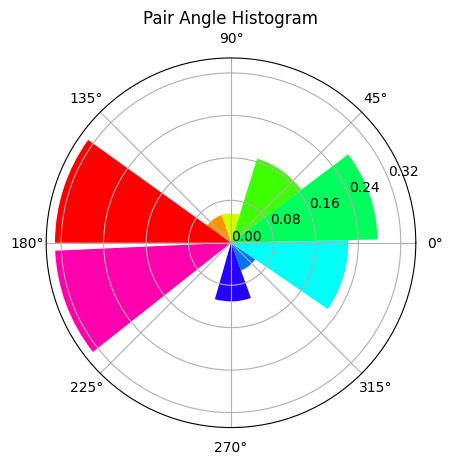

In [21]:
plot_latency_angle_hist( sd, good_pairs)

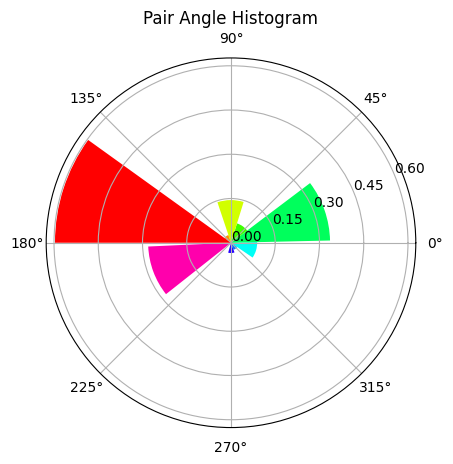

In [22]:
plot_latency_angle_hist( sd, good_pairs, by_firing_rate=True)

In [23]:
plot_cross_sttc_pairs( sd, good_pairs )

interactive(children=(IntSlider(value=14, description='num', max=28), Button(description='Run Interact', style…

# <font color="brown"> Plot Vector Layout 2

In [8]:
#!/usr/bin/env python3

from matplotlib import pyplot as plt
from matplotlib.patches import FancyArrow
from sklearn import preprocessing
import numpy as np
from human_hip.spike_data import latencies, latency_times, plot_raster, plot_footprint, cross_sttc
from braingeneers.analysis.analysis import SpikeData
import warnings
import diptest 
import math
import matplotlib.cm as cm
from ipywidgets import interact_manual
from matplotlib.ticker import MaxNLocator

In [9]:
image_path="/workspaces/human_hippocampus/data/histology/hc112823_bw_old.png"
xlim=(0,2000)
ylim=(0,1600) 
pairs = good_pairs
figsize=(8, 8)
ms_cutoff_high=20

/tmp/ipykernel_67376/3048106623.py:2: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for neuron in sd.neuron_data[0].values():
/tmp/ipykernel_67376/3048106623.py:43: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('hsv')


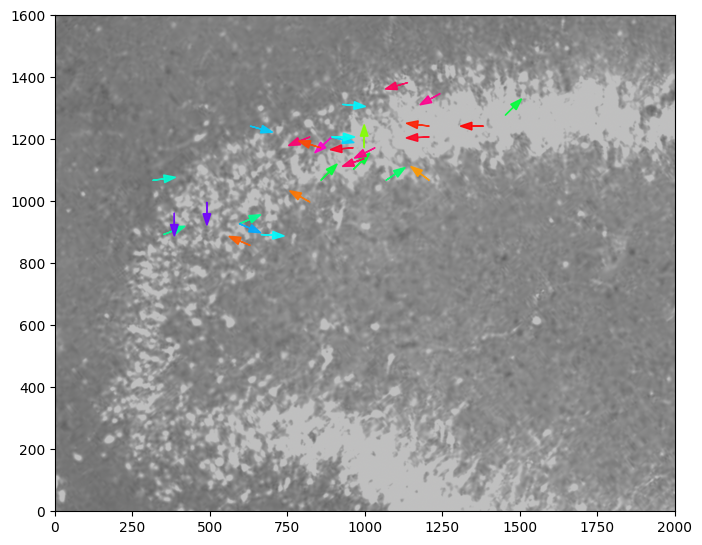

In [10]:
    neuron_xy = []
    for neuron in sd.neuron_data[0].values():
        neuron_xy.append( [neuron['position'][0], neuron['position'][1]] )
    neuron_xy = np.array(neuron_xy)

    # organize pair directions
    pairs = pairs                         # make a copy of pairs, this avoids some bug
    for i in range(len(pairs)):
        lag = np.median(latencies( pairs[i][0], pairs[i][1], sd, ms_cutoff_high=ms_cutoff_high))
        if lag<0:
            pairs[i] = [ pairs[i][1], pairs[i][0] ]

    starts = neuron_xy[ pairs[:,0] ]  # Get the x/y locations of the start and end neurons of each pair
    ends = neuron_xy[ pairs[:,1] ]
    centered = ends-starts   # Get the directions of arrows, then make of of them the same length
    normalized = preprocessing.normalize(centered) #* 75
    angles = np.arctan2( normalized[:, 1], normalized[:, 0] ) 


    # clump by starting pair angle
    pair_dict = {}
    for i in range(len(pairs)):
        key, value = pairs[i]
        if key in pair_dict:
            pair_dict[key].append( angles[i] )
        else:
            pair_dict[key] = [ angles[i] ]

    # create new dictionary of just mean angles
    for key, value in pair_dict.items():
        pair_dict[key] = sum(value) / len(value)

    # Plot original scatter
    plt.figure(figsize=(8, 8))
    ax = plt.axes()
    if image_path is not None:
        img = plt.imread(image_path)      # Load in image
        plt.imshow(img,  extent=[0, 3850, 0, 2100]) 
    plt.xlim( xlim )
    plt.ylim( ylim )    

    # Draw Arrows
    cmap = cm.get_cmap('hsv')
    for pair, angle in pair_dict.items():
        angle2 = (angle*-1+ np.pi)/np.pi/2

        start = neuron_xy[ pair ]  
        arrow = FancyArrow( 
                start[0], start[1], np.cos(angle)*75 , np.sin(angle)*75, length_includes_head=True, head_width=25,
                linewidth=1, color=cmap(angle2,alpha=0.9)  ) #color="red"
        plt.gca().add_patch(arrow)


In [11]:
#neuron_xy
#pairs
#angles
#pair_dict[0]
len(pair_dict)

30

In [26]:
def plot_vector_layout2( sd, pairs, image_path=None, figsize=(8, 8), xlim=None, ylim=None, ms_cutoff_high=20 ):

    # Get the x/y locations of the start and end neurons of each pair
    neuron_xy = []
    for neuron in sd.neuron_data[0].values():
        neuron_xy.append( [neuron['position'][0], neuron['position'][1]] )
    neuron_xy = np.array(neuron_xy)

    # organize pair directions
    pairs = pairs                         # make a copy of pairs, this avoids some bug
    for i in range(len(pairs)):
        lag = np.median(latencies( pairs[i][0], pairs[i][1], sd, ms_cutoff_high=ms_cutoff_high))
        if lag<0:
            pairs[i] = [ pairs[i][1], pairs[i][0] ]

    starts = neuron_xy[ pairs[:,0] ]  # Get the x/y locations of the start and end neurons of each pair
    ends = neuron_xy[ pairs[:,1] ]
    centered = ends-starts   # Get the directions of arrows, then make of of them the same length
    normalized = preprocessing.normalize(centered) #* 75
    angles = np.arctan2( normalized[:, 1], normalized[:, 0] ) 

    # clump by starting pair angle
    pair_dict = {}
    for i in range(len(pairs)):
        key, value = pairs[i]
        if key in pair_dict:
            pair_dict[key].append( angles[i] )
        else:
            pair_dict[key] = [ angles[i] ]

    # create new dictionary of just mean angles
    for key, value in pair_dict.items():
        pair_dict[key] = sum(value) / len(value)


    # Plot original scatter
    plt.figure(figsize=(8, 8))
    ax = plt.axes()
    if image_path is not None:
        img = plt.imread(image_path)      # Load in image
        plt.imshow(img,  extent=[0, 3850, 0, 2100]) 
    plt.xlim( xlim )
    plt.ylim( ylim )    

    # Draw Arrows
    cmap = cm.get_cmap('hsv')
    for pair, angle in pair_dict.items():
        angle2 = (angle*-1+ np.pi)/np.pi/2

        start = neuron_xy[ pair ]  
        arrow = FancyArrow( 
                start[0], start[1], np.cos(angle)*75 , np.sin(angle)*75, length_includes_head=True, head_width=25,
                linewidth=1, color=cmap(angle2,alpha=0.9)  ) #color="red"
        plt.gca().add_patch(arrow)



/tmp/ipykernel_442/4141140927.py:5: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for neuron in sd.neuron_data[0].values():
/tmp/ipykernel_442/4141140927.py:46: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('hsv')


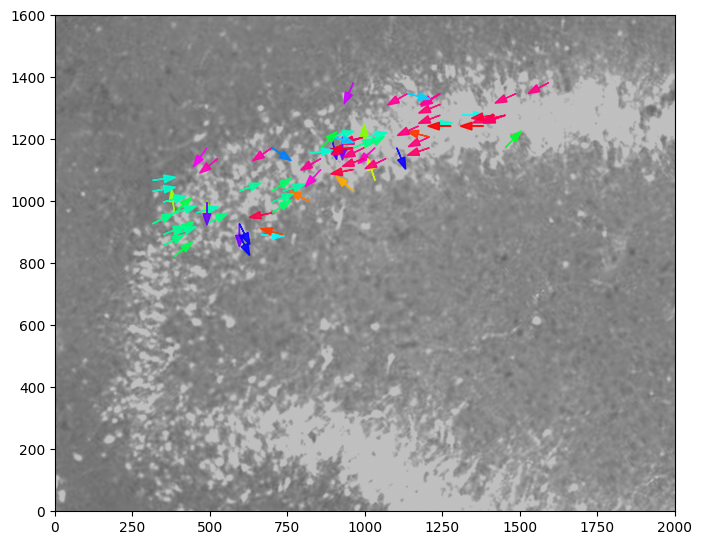

In [28]:
plot_vector_layout2(sd, good_pairs, image_path="/workspaces/human_hippocampus/data/histology/hc112823_bw_old.png",
                    xlim=(0,2000), ylim=(0,1600), figsize=(8, 8), ms_cutoff_high=20)

# Vector Plots

In [9]:
@interact_manual(num=(0,len(good_pairs)-1))
def analyzePair(num):
    plot_pair_analysis( good_pairs[num][0], good_pairs[num][1], sd)

interactive(children=(IntSlider(value=50, description='num', max=101), Button(description='Run Interact', styl…

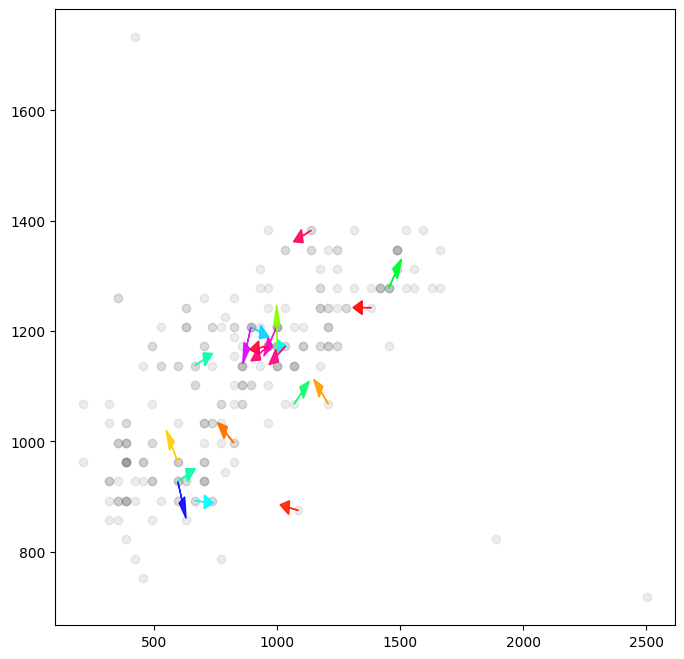

In [13]:
plot_vector_layout( sd, good_pairs)

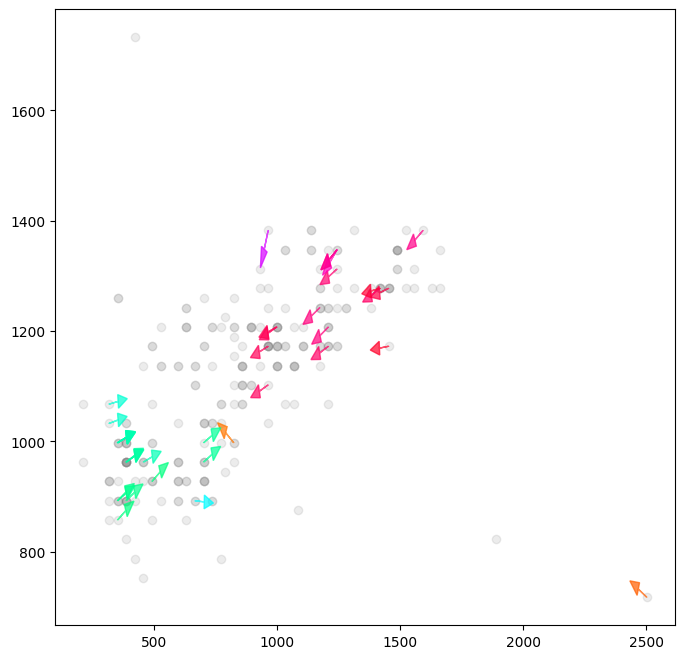

In [8]:
plot_vector_layout( sd, good_pairs, min_dist=500 )